In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import tri, cm
from tqdm import tqdm
import pandas as pd
from tools import *

Definições Geométricas

In [2]:
Lx = 1
Nx = 100

Ly = 1
Ny = 100

Npoints = Nx*Ny

In [3]:
X = np.linspace(0, Lx, Nx, dtype = float)
Y = np.linspace(0, Ly, Ny, dtype = float)

Xv, Yv = np.meshgrid(X, Y)

X = np.reshape(Xv, Npoints)
Y = np.reshape(Yv, Npoints)

In [4]:
# nos de condicao de contorno
cc1 = np.arange(           start = 0,           stop = Nx,  step = 1) # bottom 
cc2 = np.arange(          start = Nx, stop = Npoints - Nx, step = Nx) # left
cc3 = np.arange(start = Npoints - Nx,      stop = Npoints,  step = 1) # top
cc4 = np.arange(    start = 2*Nx - 1, stop = Npoints - Nx, step = Nx) # right

cc = np.hstack([cc1,cc2,cc3,cc4])

core = np.hstack([np.arange(Nx + 1, 2*Nx - 1, 1) + Nx*j for j in range(0,Ny - 2)])

In [5]:
Msh = Mesh_class(X, Y, [], cc, core)

In [6]:
IEN_temp = [
    [0, Nx + 1, Nx    ],
    [0,      1, Nx + 1]
]

for i in range(Ny - 1):
    for j in range(Nx - 2):
        IEN_temp.append([IEN_temp[-2][k] + 1 for k in range(3)])
        IEN_temp.append([IEN_temp[-2][k] + 1 for k in range(3)])

    if i < Ny - 2:
        IEN_temp.append([IEN_temp[0][k] + Nx*(i + 1) for k in range(3)])
        IEN_temp.append([IEN_temp[1][k] + Nx*(i + 1) for k in range(3)])

IEN_temp = np.array(IEN_temp)

IEN_Tri = IEN_domain_class(Msh, 'Tri', IEN_temp, 'volume')

In [21]:
IEN_temp1 = np.array([[ii, ii + Nx] for ii in np.arange(0          , Nx*(Ny - 1),  Nx)])
IEN_temp2 = np.array([[ii, ii +  1] for ii in np.arange(Nx*(Ny - 1), Nx*Ny - 1  ,   1)])
IEN_temp3 = np.array([[ii, ii - Nx] for ii in np.arange(Nx*Ny - 1  , Nx - 1     , -Nx)])
IEN_temp4 = np.array([[ii, ii -  1] for ii in np.arange(Nx - 1     , 0          , - 1)])

IEN_temp = np.concatenate([IEN_temp1, IEN_temp2, IEN_temp3, IEN_temp4])

IEN_temp1_type = np.full(IEN_temp1.shape[0], 'Dirichlet')
IEN_temp2_type = np.full(IEN_temp2.shape[0], 'Dirichlet')
IEN_temp3_type = np.full(IEN_temp3.shape[0], 'Dirichlet')
IEN_temp4_type = np.full(IEN_temp4.shape[0], 'Robin')

IEN_temp_type = np.concatenate([IEN_temp1_type, IEN_temp2_type, IEN_temp3_type, IEN_temp4_type])

IEN_temp1_prescription = np.full(IEN_temp1.shape[0],           {'T': 80})
IEN_temp2_prescription = np.full(IEN_temp2.shape[0],           {'T': 90})
IEN_temp3_prescription = np.full(IEN_temp3.shape[0],           {'T': 80})
IEN_temp4_prescription = np.full(IEN_temp4.shape[0],{'h': 10, 'Ta': 100})

IEN_temp_prescription = np.concatenate([IEN_temp1_prescription, IEN_temp2_prescription, IEN_temp3_prescription, IEN_temp4_prescription])

IEN_Line = IEN_bc_class(Msh, 'Line', IEN_temp, IEN_temp_type, IEN_temp_prescription)

In [22]:
K  = np.zeros((Npoints, Npoints), dtype = float) 
M  = np.zeros((Npoints, Npoints), dtype = float)

In [23]:
IEN_Tri.IENFunc(K, M)

100%|██████████| 19602/19602 [00:00<00:00, 31943.92it/s]


In [24]:
IEN_Line.retrieveBCForm(IEN_Tri)

100%|██████████| 19602/19602 [00:00<00:00, 71598.48it/s]


In [25]:
A_replace, b_replace = IEN_Line.IENFunc()
# mydict = IEN_Line.IENFunc()

Definições do material

In [26]:
rho = 1
cv = 1
alpha = 1

Q = -4*rho*cv

In [27]:
qvec = np.full(Npoints, Q/(rho*cv))

A = (alpha*K).copy()
b = M@qvec

In [28]:
def replace_lines(A, b, A_replace, b_replace):
    N = b.shape[0]

    for i in tqdm(range(N)):
        if b_replace[i] is not None:
            b[i] = b_replace[i]

        if A_replace[i] is not None:
            A[i] = A_replace[i]

In [29]:
replace_lines(A, b, A_replace, b_replace)

100%|██████████| 10000/10000 [00:00<00:00, 512694.69it/s]


In [30]:
A_inv = np.linalg.inv(A)

In [32]:
T_vec = A_inv@b
T_mat = np.reshape(A_inv@b, (Nx, Ny))

In [33]:
triang = tri.Triangulation(X,Y)

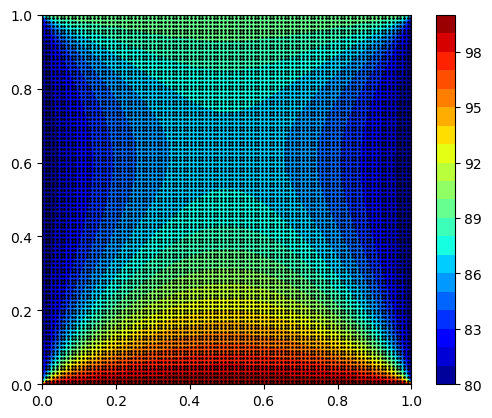

In [34]:
# For graphical purposes
Tmin = min(T_vec)
Tmax = max(T_vec)

# Temperature contourplot
ax = plt.axes()
ax.set_aspect('equal')
ax.triplot(triang,'k.', markersize = 2)
surf = ax.tricontourf(triang,T_vec,cmap='jet', levels = np.linspace(Tmin, Tmax, 21))
plt.colorbar(surf)
plt.show()

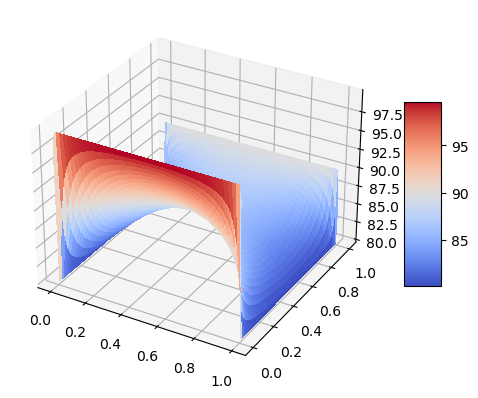

In [35]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
Xz = np.reshape(X, (Nx, Ny))
Yz = np.reshape(Y, (Nx, Ny))
Tz = np.reshape(T_mat, (Nx, Ny))

# Plot the surface.
surf = ax.plot_surface(Xz, Yz, Tz, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

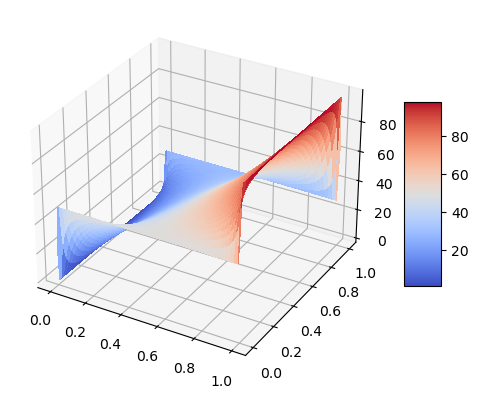

In [21]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

Error = T_vec - X**2 - Y**2

# Make data.
Xz = np.reshape(X, (Nx, Ny))
Yz = np.reshape(Y, (Nx, Ny))
Errorz = np.reshape(Error, (Nx, Ny))

# Plot the surface.
surf = ax.plot_surface(Xz, Yz, Errorz, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### Manufactured Solution

In [23]:
T_manu = lambda x, y: x*x + y*y

In [ ]:
# nos de condicao de contorno
cc1 = np.arange(           start = 0,           stop = Nx,  step = 1) # bottom 
cc2 = np.arange(          start = Nx, stop = Npoints - Nx, step = Nx) # left
cc3 = np.arange(start = Npoints - Nx,      stop = Npoints,  step = 1) # top
cc4 = np.arange(    start = 2*Nx - 1, stop = Npoints - Nx, step = Nx) # right

cc1_type = np.full(cc1.shape[0], 'dirichlet')
cc2_type = np.full(cc2.shape[0],   'neumann')
cc3_type = np.full(cc3.shape[0], 'dirichlet')
cc4_type = np.full(cc4.shape[0],   'neumann')

cc = np.hstack([cc1,cc2,cc3,cc4])
cc_type = np.hstack([cc1_type,cc2_type,cc3_type,cc4_type])

core = np.hstack([np.arange(Nx + 1, 2*Nx - 1, 1) + Nx*j for j in range(0,Ny - 2)])

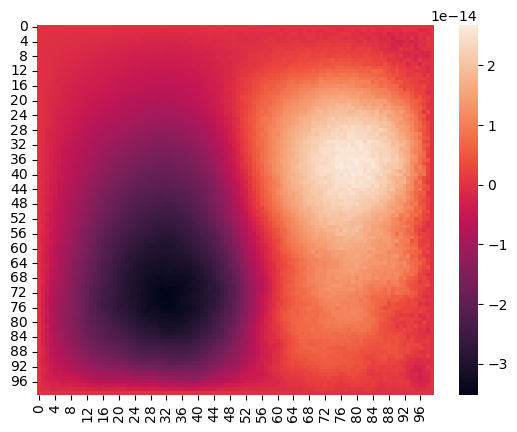

In [30]:
sns.heatmap(np.reshape(Error, (Nx, Ny)))
plt.show()